# `SkySensitivity` Tutorial
This tutorial is an introduction to the `skymap` module of the pulsar timing array sensitivity curve package `hasasia`. For an introduction to straight forward sensitivity curves see prior tutorials. 

In [1]:
#Import the usual suspects.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# You'll need these packages to make the skymaps and deal with units. 
import healpy as hp
import astropy.units as u
import astropy.constants as c

In [2]:
#Import the needed modules.
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['text.usetex'] = True

In [4]:
#Make a set of random sky positions
phi = np.random.uniform(0, 2*np.pi,size=33)
cos_theta = np.random.uniform(-1,1,size=33)
theta = np.arccos(cos_theta)

#Adding one well-placed sky position for plots.
phi = np.append(np.array(np.deg2rad(60)),phi)
theta = np.append(np.array(np.deg2rad(50)),theta)

#Define the timsespans and TOA errors for the pulsars
timespans = np.random.uniform(3.0,11.4,size=34)
Tspan = timespans.max()*365.25*24*3600
sigma = 1e-7 # 100 ns

Here we use the `sim_pta` method in the `hasasia.sim` module to simulate a set of `hasasia.senstivity.Pulsar` objects. This function takes either single values or lists/array as inputs for the set of pulsars. 

In [5]:
#Simulate a set of identical pulsars, with different sky positions. 
psrs = hsim.sim_pta(timespan=11.4, cad=23, sigma=sigma,
                    phi=phi, theta=theta)

Next define the frequency range over which to characterize the spectra for the pulsars and enter each `Pulsar` object into a `hasasia.sensitivity.Spectrum` object. 

In [6]:
freqs = np.logspace(np.log10(1/(5*Tspan)),np.log10(2e-7),500)
spectra = []
for p in psrs:
    sp = hsen.Spectrum(p, freqs=freqs)
    sp.NcalInv
    spectra.append(sp)

Note above that we have called `sp.NcalInv`, which calculates the inverse-noise-weighted transmission function for the pulsar along the way. For realistic pulsars with +100k TOAs this step will take the most time.

Before defining a `hasasia.skymap.SkySensitivity` object we will need to choose a set of sky locations. Here we use the `healpy` Python package to give us a healpix pixelation of the sky. 

In [7]:
#Use the healpy functions to get the sky coordinates
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

Next enter the list of `Spectrum` objects and the sky coordinates into the `SkySensitivity` class.  

In [8]:
SM=hsky.SkySensitivity(spectra,theta_gw, phi_gw)

The `SkySensitivity` class has a number of accessible attributes and methods. The polarization tensors :math:`e^+` and :math:`e^-` are available. 

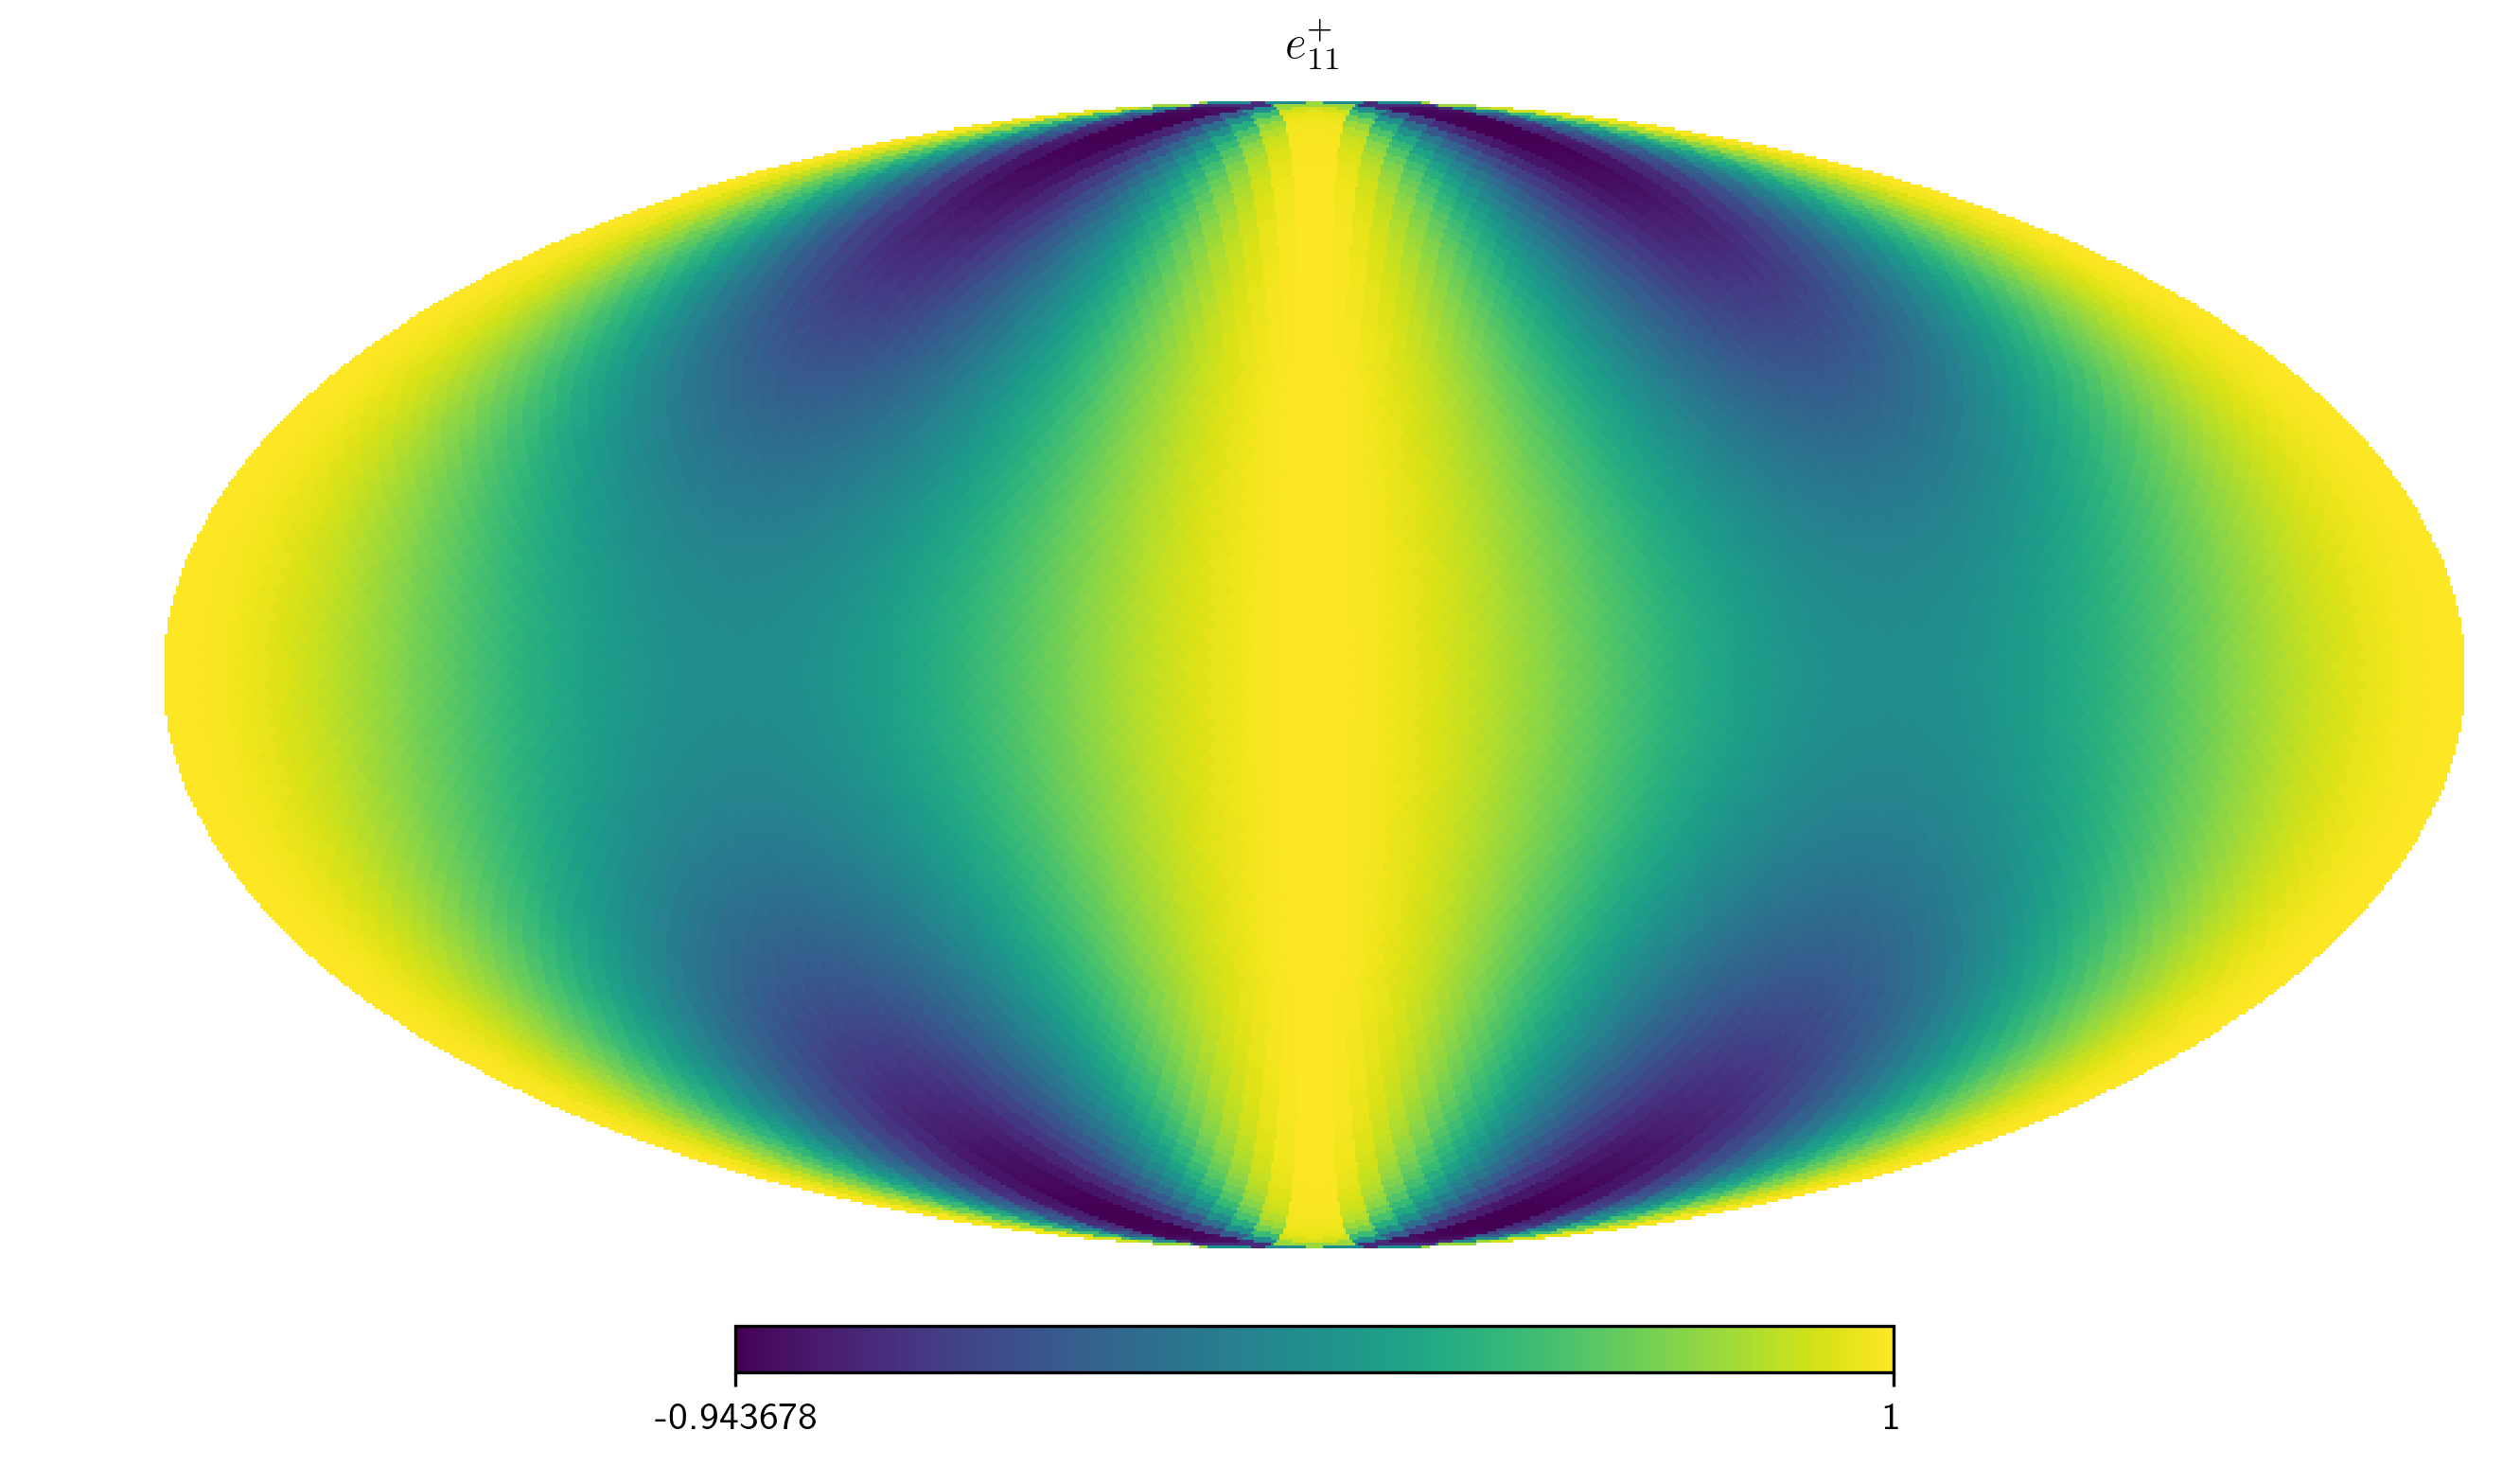

In [9]:
hp.mollview(SM.eplus[1,1,:], title='$e_{11}^+$',)

One can also access the residual response functions for each of the individual pulsars, as `SkySensitivity.Rplus` and `SkySensitivity.Rcross`.

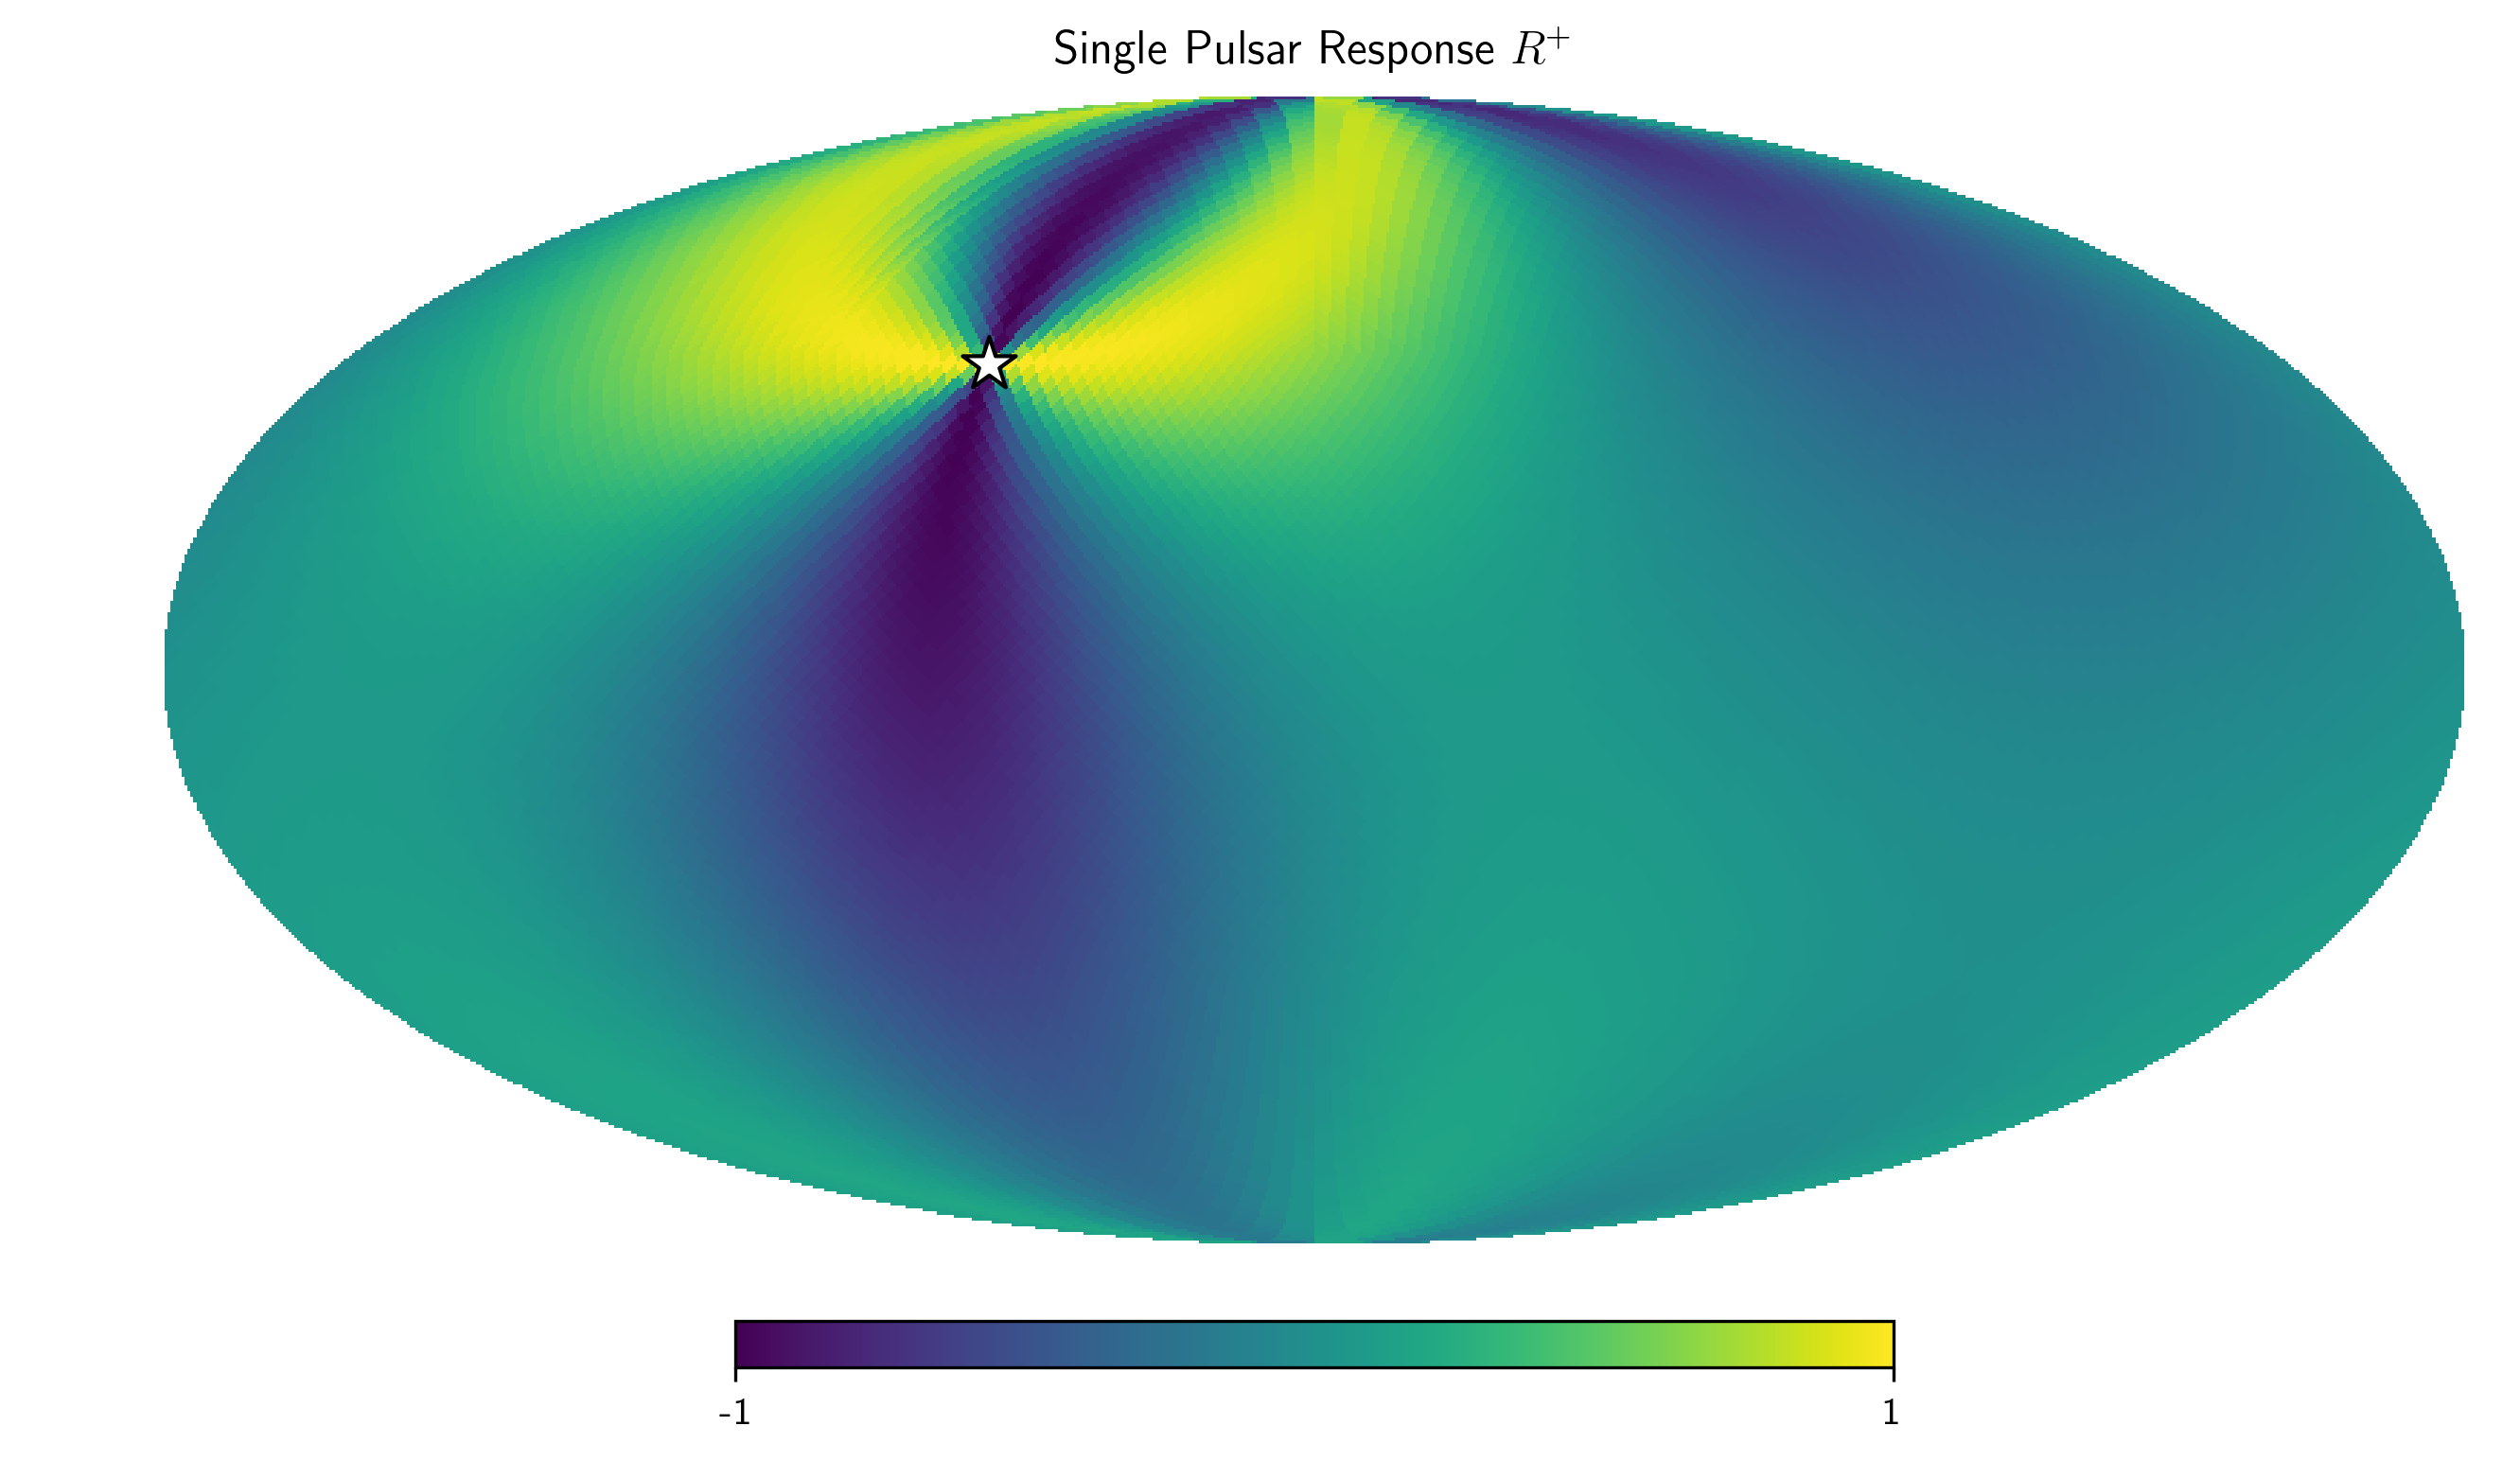

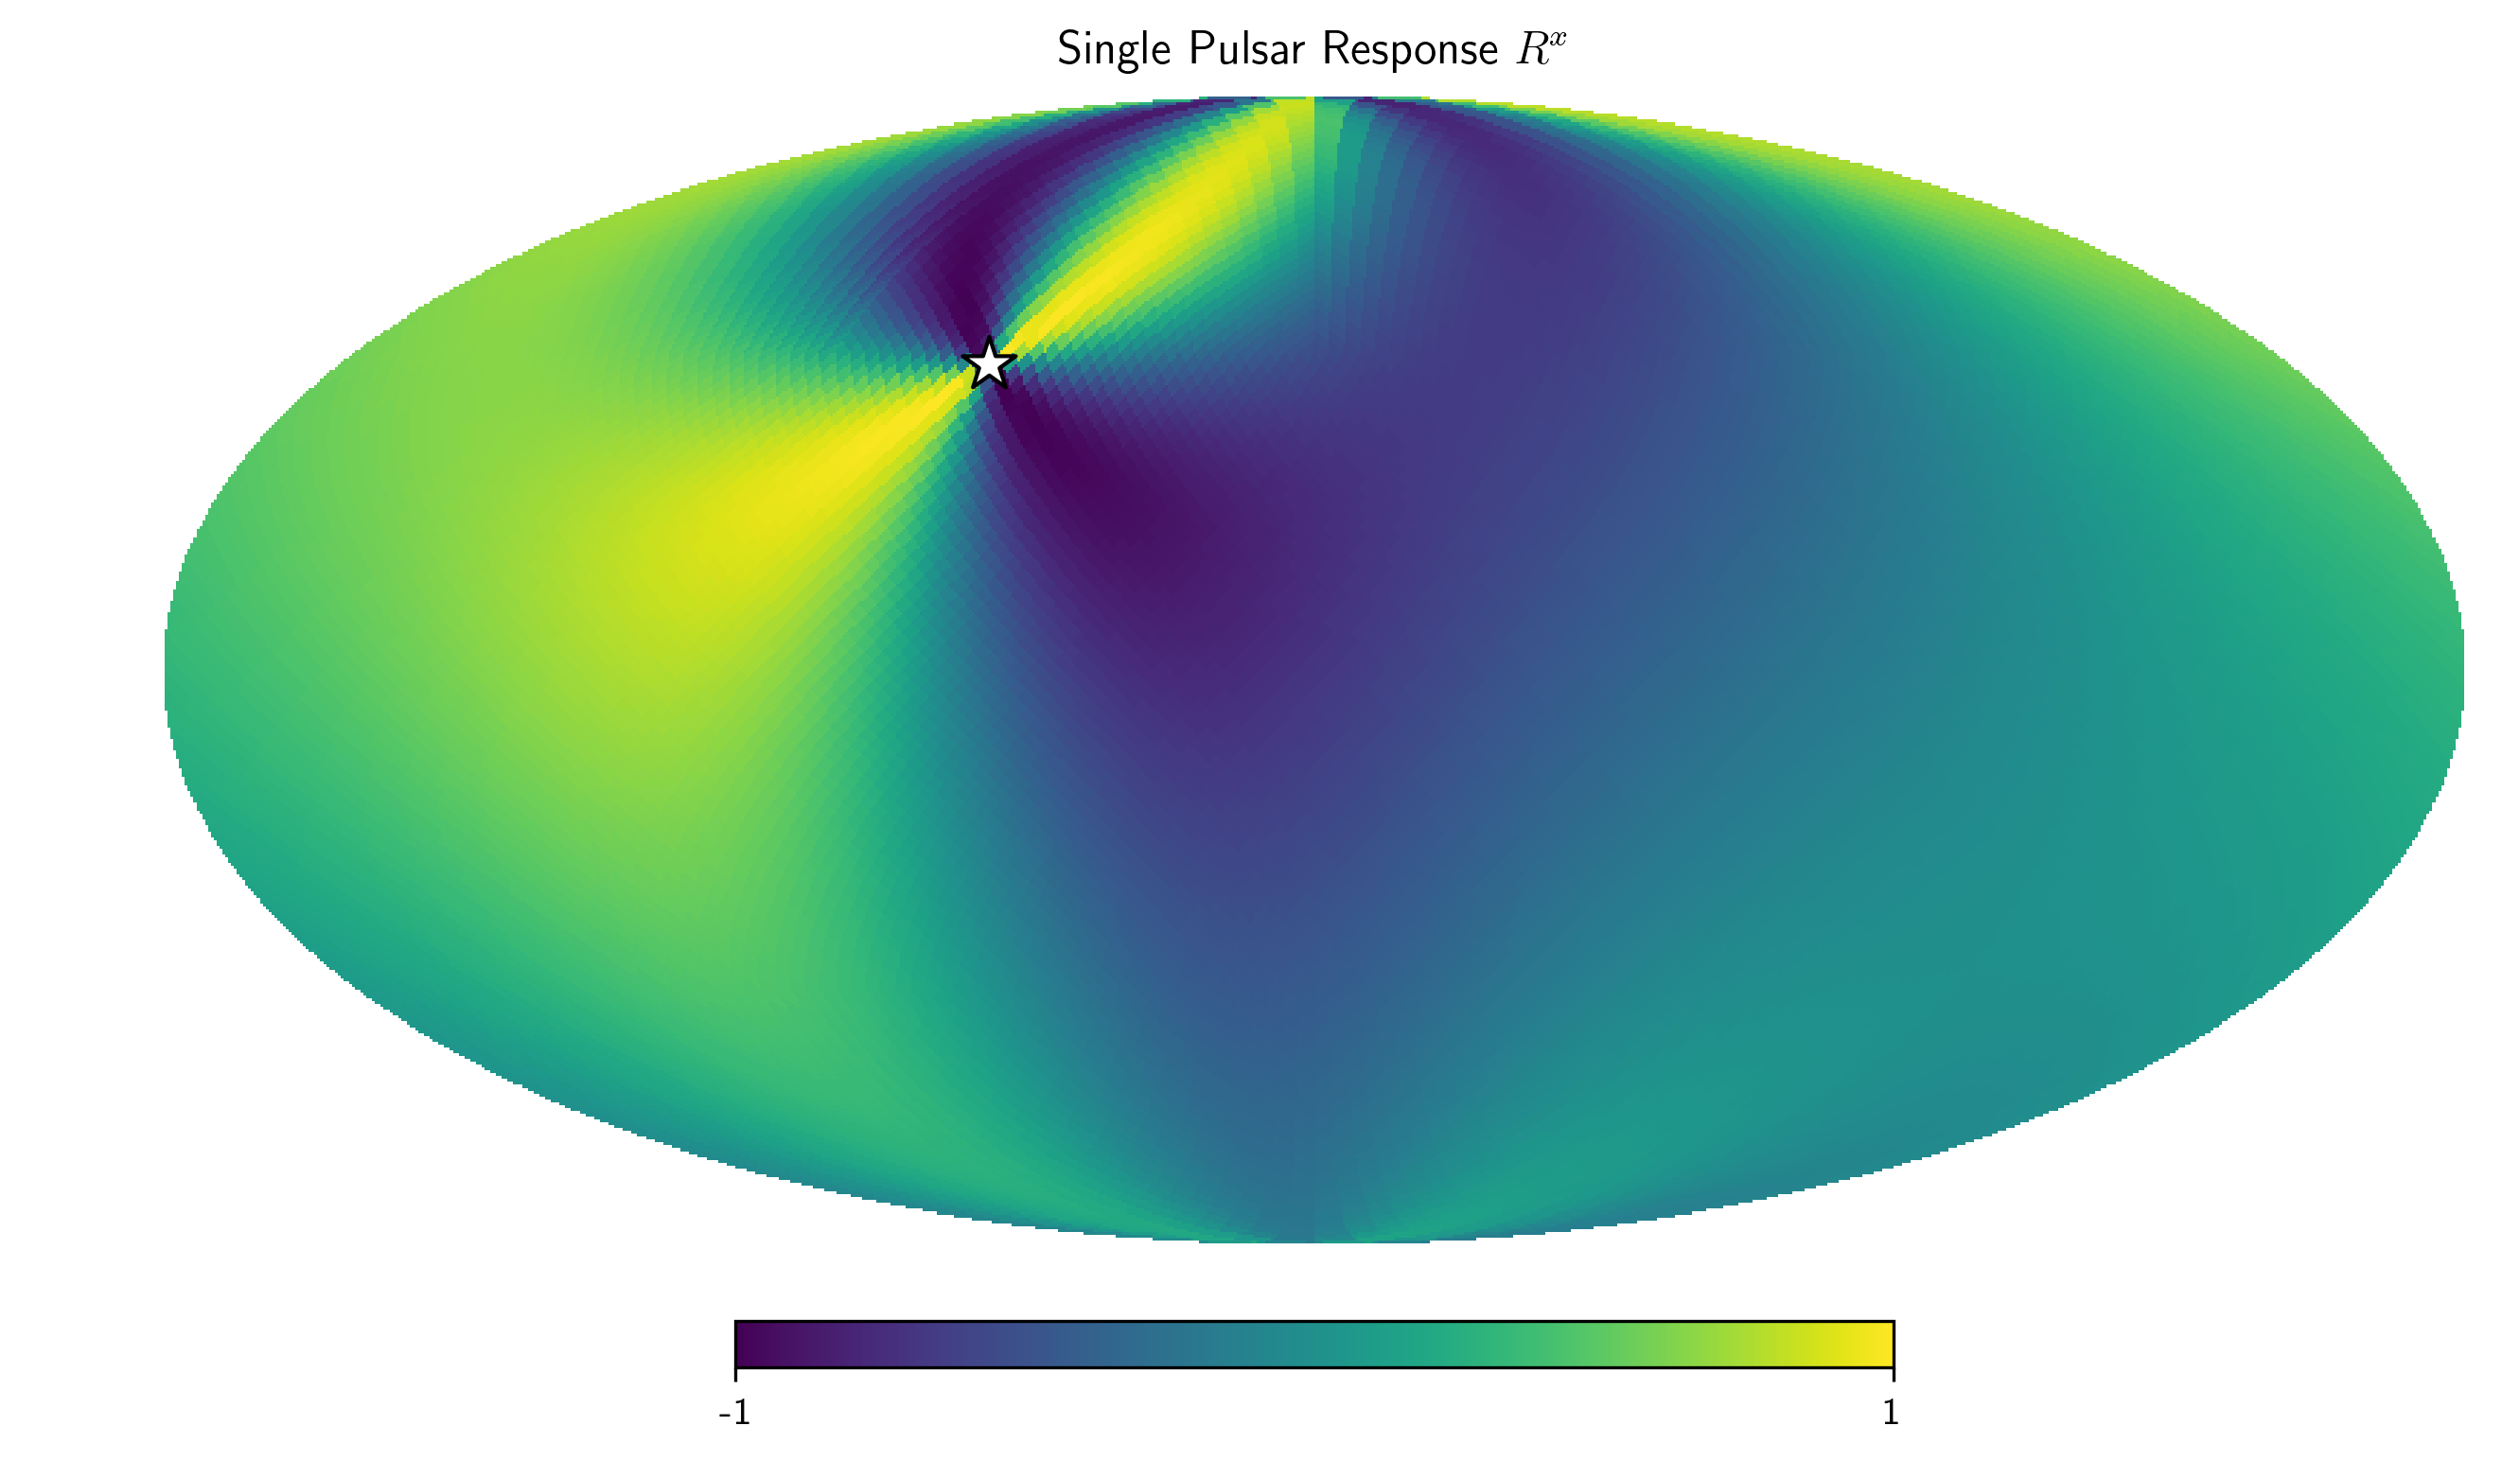

In [10]:
idx = 0
hp.mollview(SM.Rplus[idx], fig=1,
            title="Single Pulsar Response $R^+$",min=-1,max=1)
hp.visufunc.projscatter(SM.thetas[idx],SM.phis[idx],
                        marker='*',color='white',
                        edgecolors='k',s=200)
hp.mollview(SM.Rcross[idx], fig=2,
            title="Single Pulsar Response $R^x$",min=-1,max=1)
hp.visufunc.projscatter(SM.thetas[idx],SM.phis[idx],
                        marker='*',color='white',
                        edgecolors='k',s=200)

plt.show()

And the full residual response as `SkySensitivity.sky_response`.

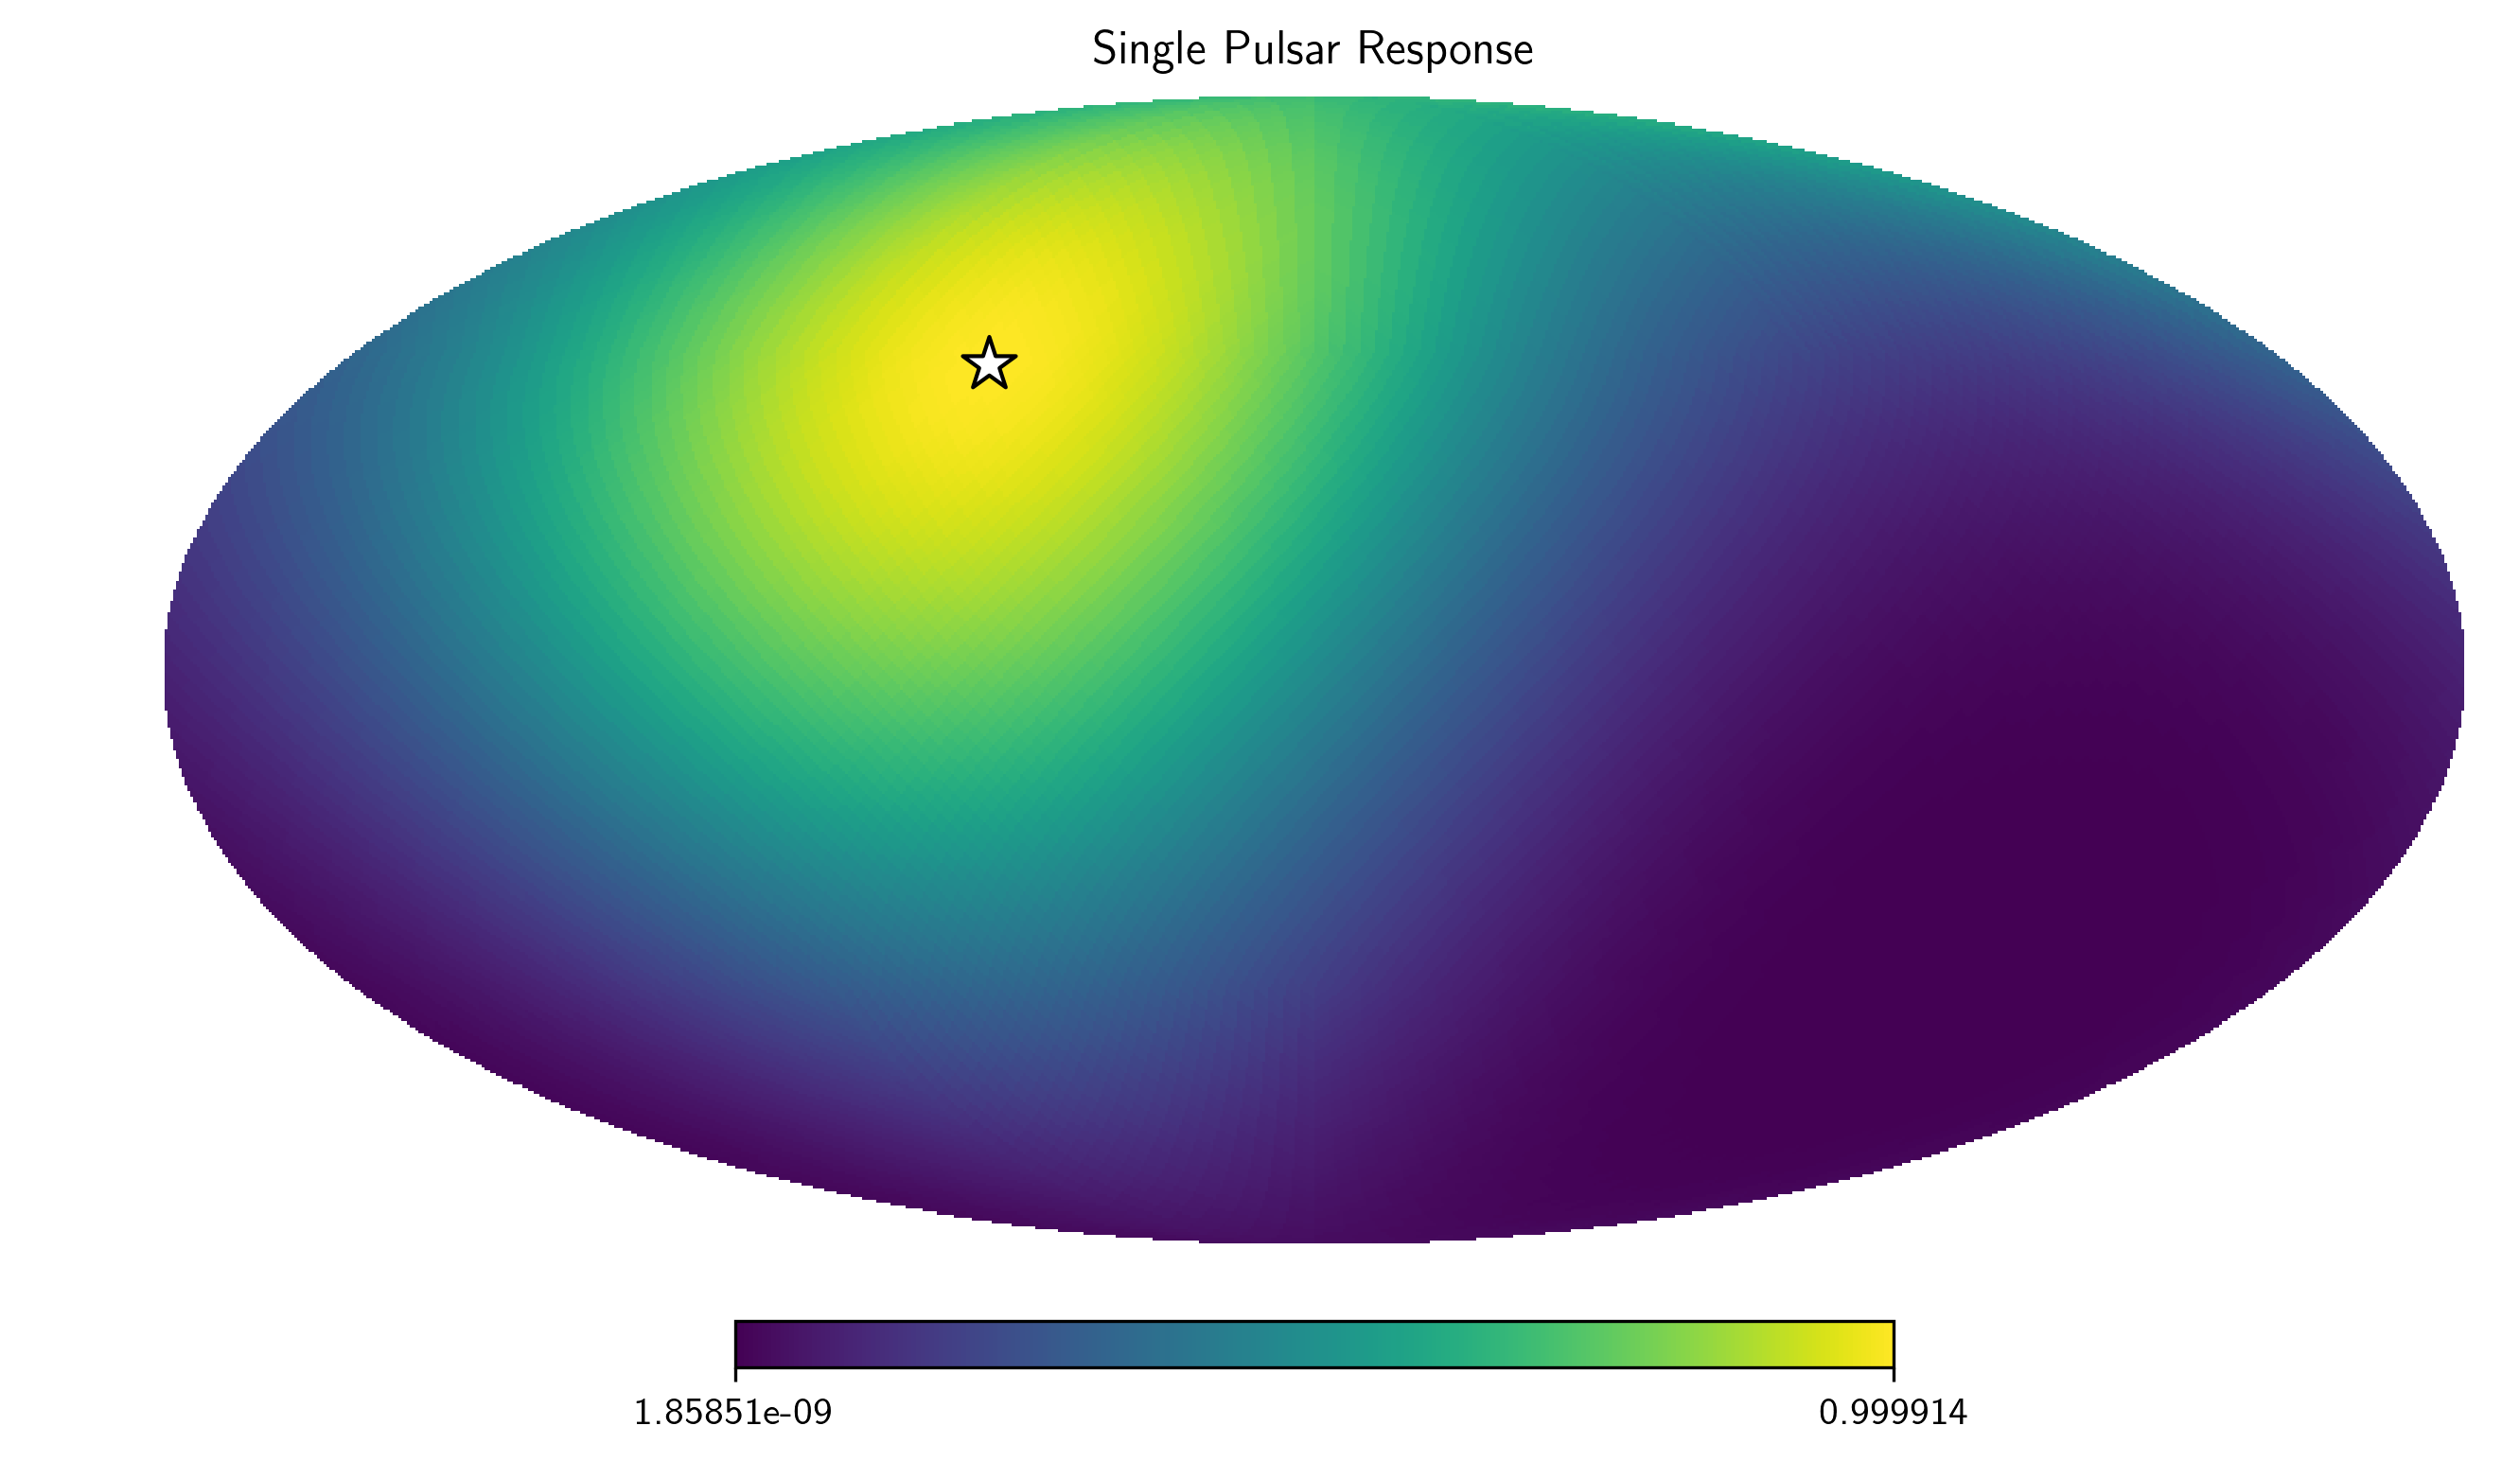

In [11]:
idx =0
hp.mollview(SM.sky_response[idx], title="Single Pulsar Response")
hp.visufunc.projscatter(SM.thetas[idx], SM.phis[idx],
                        marker='*',color='white',
                        edgecolors='k',s=200)
plt.show()

The full frequency and sky location sensitivity information is available as `SkySensitivity.S_effSky`. The first index is across frequency, while the second index is across sky position. Here we compare the sensitivity from an individual pulsar to the full PTA's senstivity at a particular sky position. 

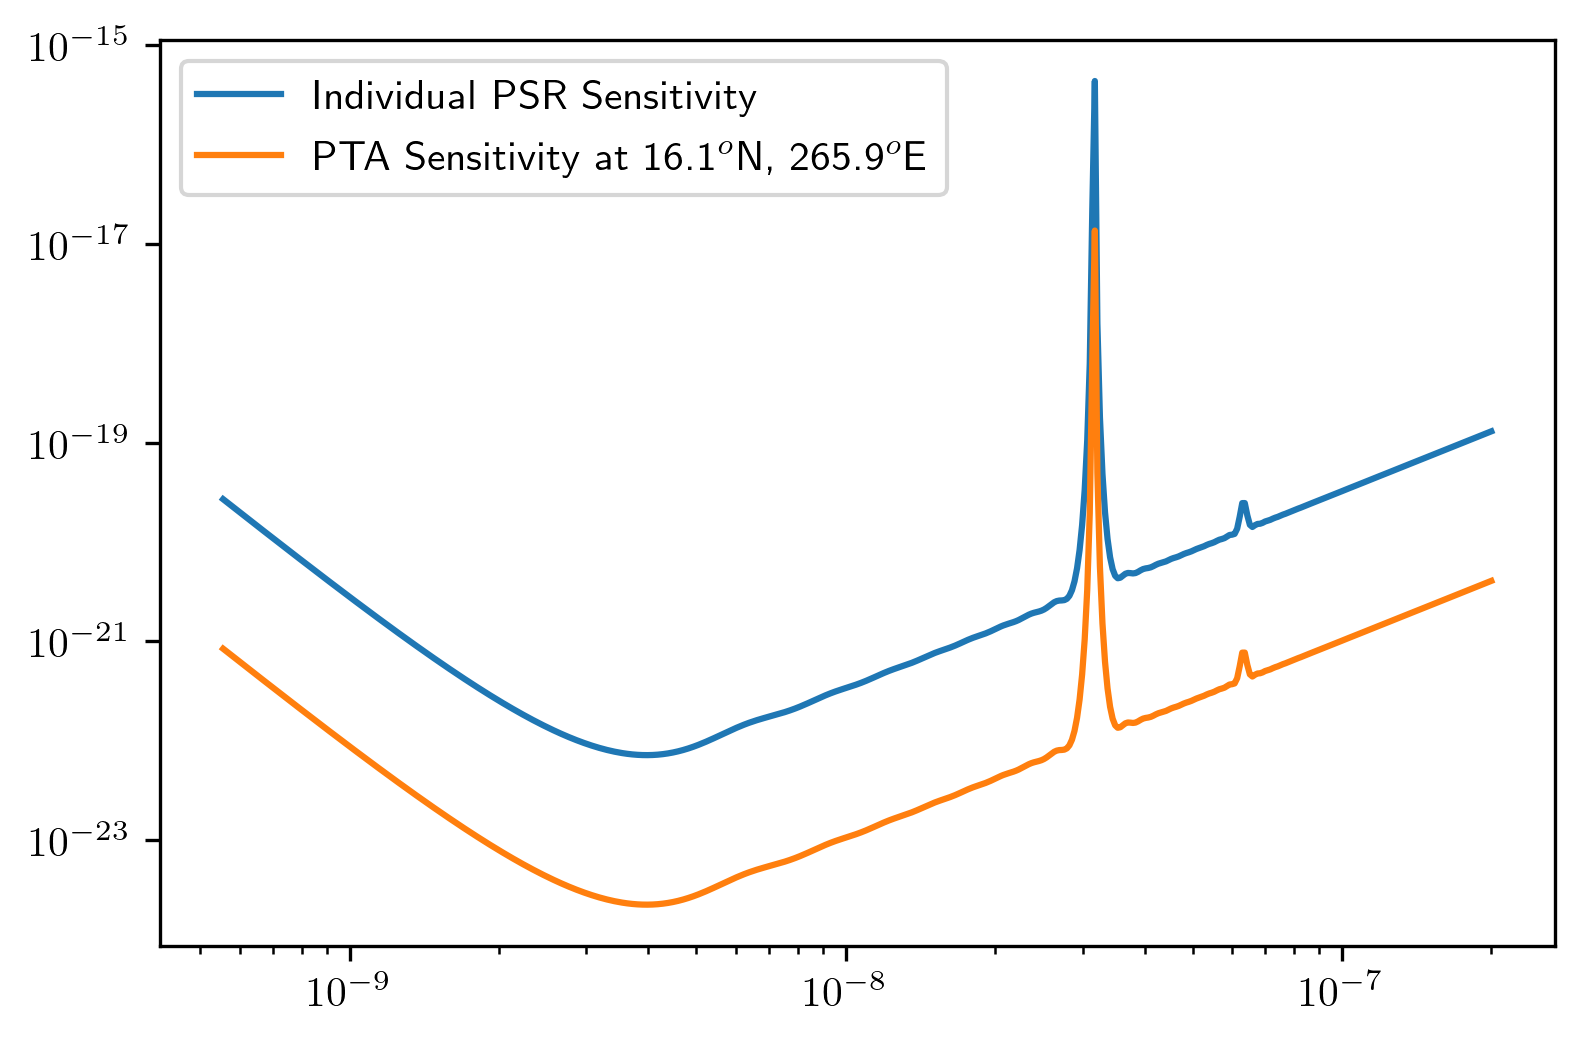

In [12]:
sky_loc = 'PTA Sensitivity at '
sky_loc += '{0:2.1f}$^o$N, {1:2.1f}$^o$E'.format(np.rad2deg(theta_gw[252]),
                                               np.rad2deg(phi_gw[252]))
plt.loglog(SM.freqs,spectra[0].S_I, label='Individual PSR Sensitivity')
plt.loglog(SM.freqs,SM.S_effSky[:,252],
           label=sky_loc)
plt.legend(loc='upper left')
plt.show()

Here we plot the `SkySensitivity.S_effSky` across the sky at a given frequency.

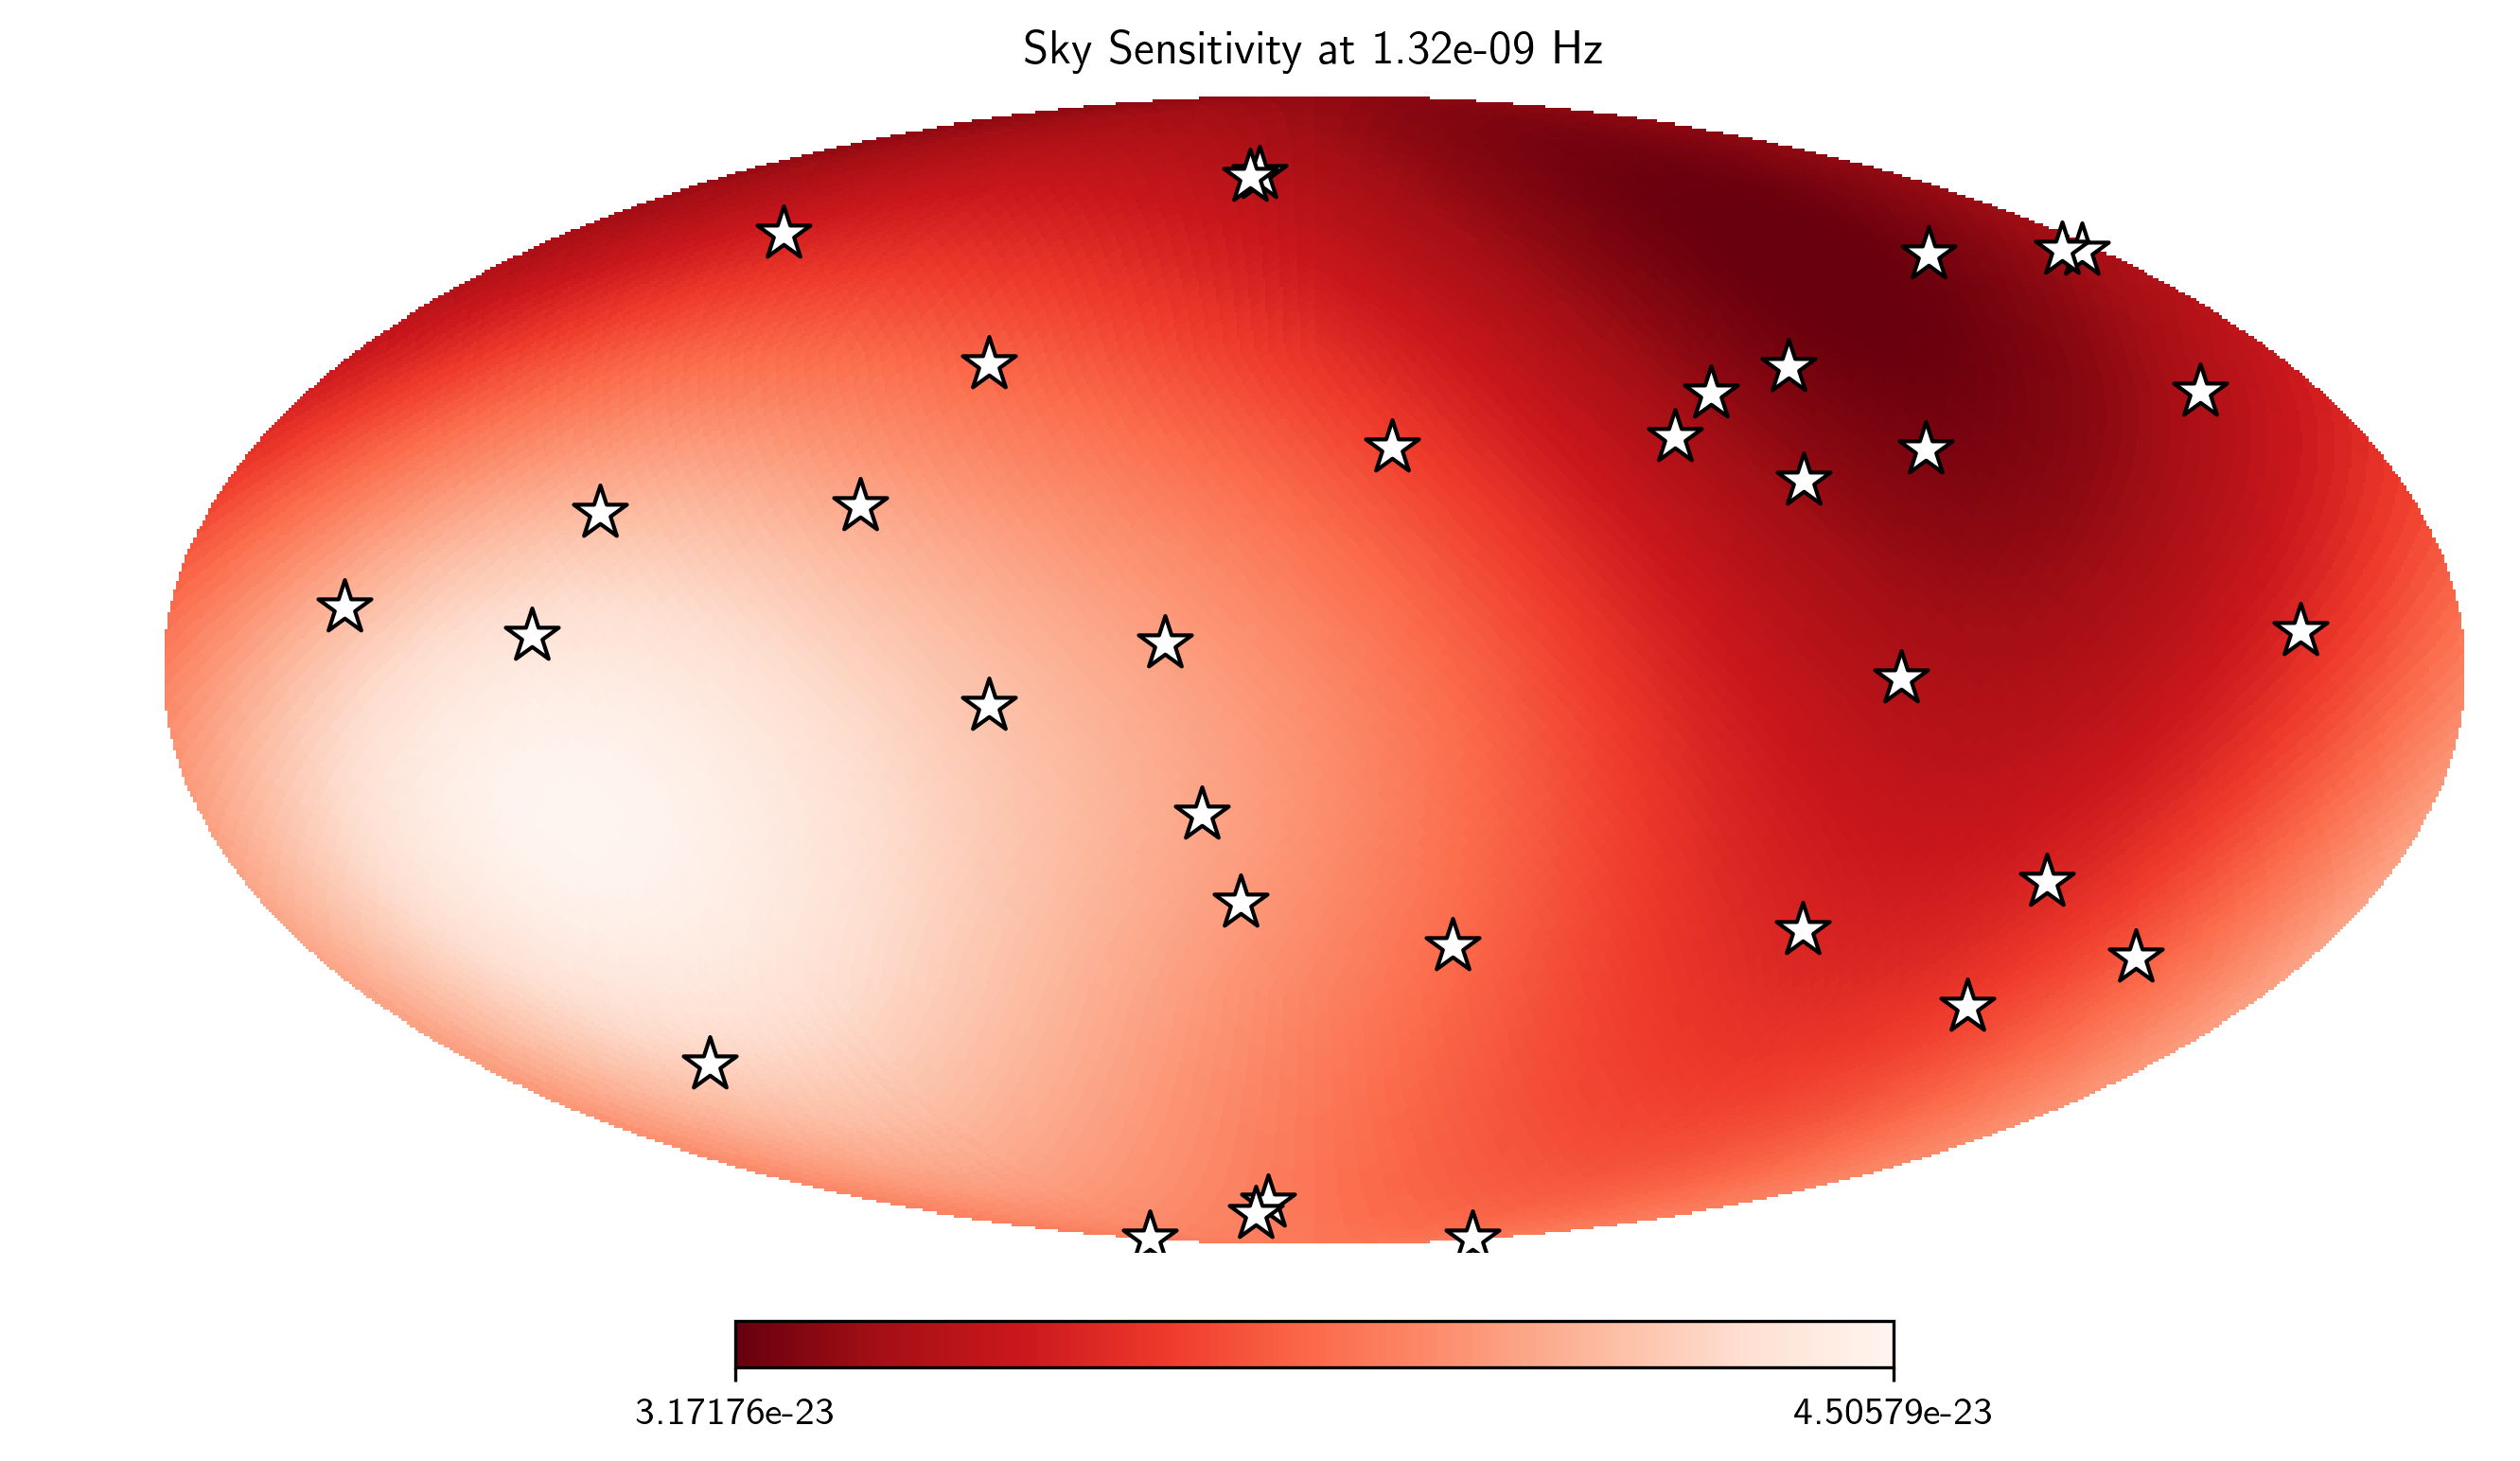

In [13]:
idx = 73
hp.mollview(SM.S_effSky[idx],
            title="Sky Sensitivity at {0:2.2e} Hz".format(SM.freqs[idx]),
            cmap='Reds_r')
hp.visufunc.projscatter(SM.thetas,SM.phis,
                        marker='*',color='white',
                        edgecolors='k',s=200)
plt.show()

The `SkySensitivity.S_effSky` class comes with a method for calculating the signal-to-noise ratio for a given signal. Rather than calculate a signal from a single sky position, the method will calculate the SNR from every sky position initially provided, given a particular signal provided in strain across the frequency band.

There is a convenience funcgion for circular binaries provided as `hasasia.skymap.h_circ`.

In [14]:
hCirc = hsky.h_circ(1e9,200,5e-9,Tspan,SM.freqs).to('')

Here we plot the signal in the frequency domain, for a finite integration time provided as the time span of the data set.

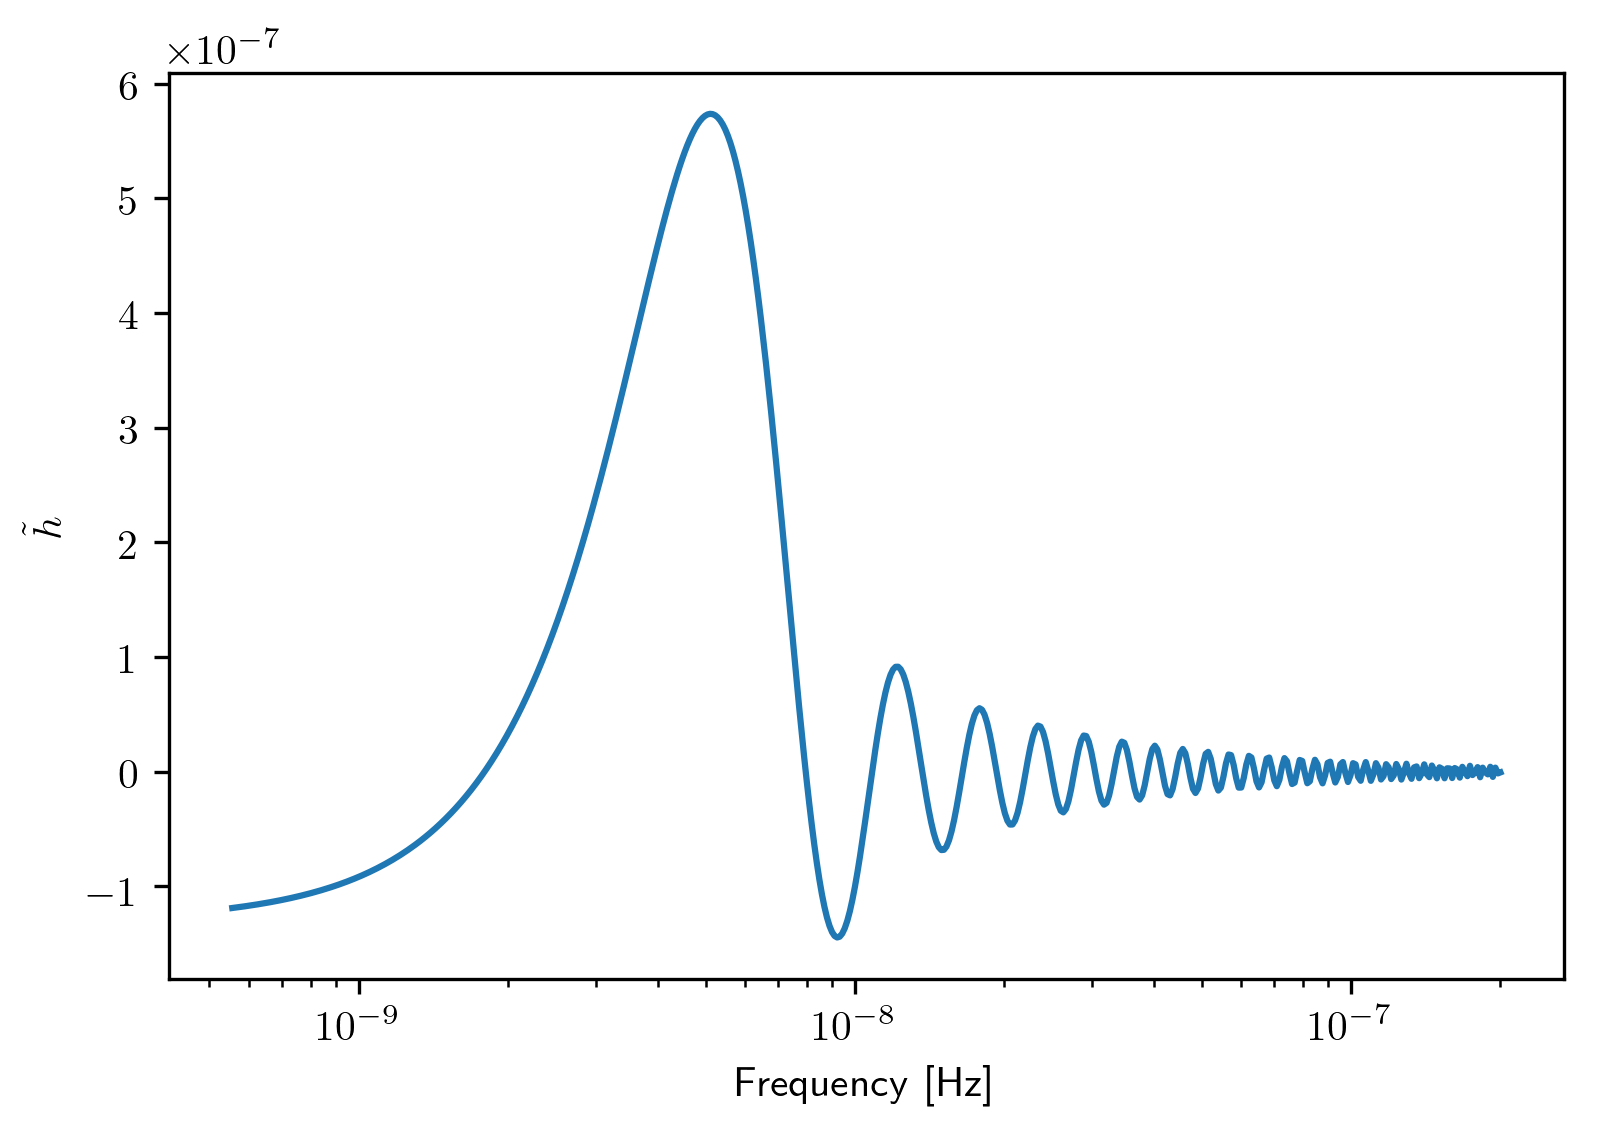

In [15]:
plt.semilogx(SM.freqs, hCirc)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\tilde{h}$')
plt.show()

In [16]:
SNR = SM.SNR(hCirc.value)

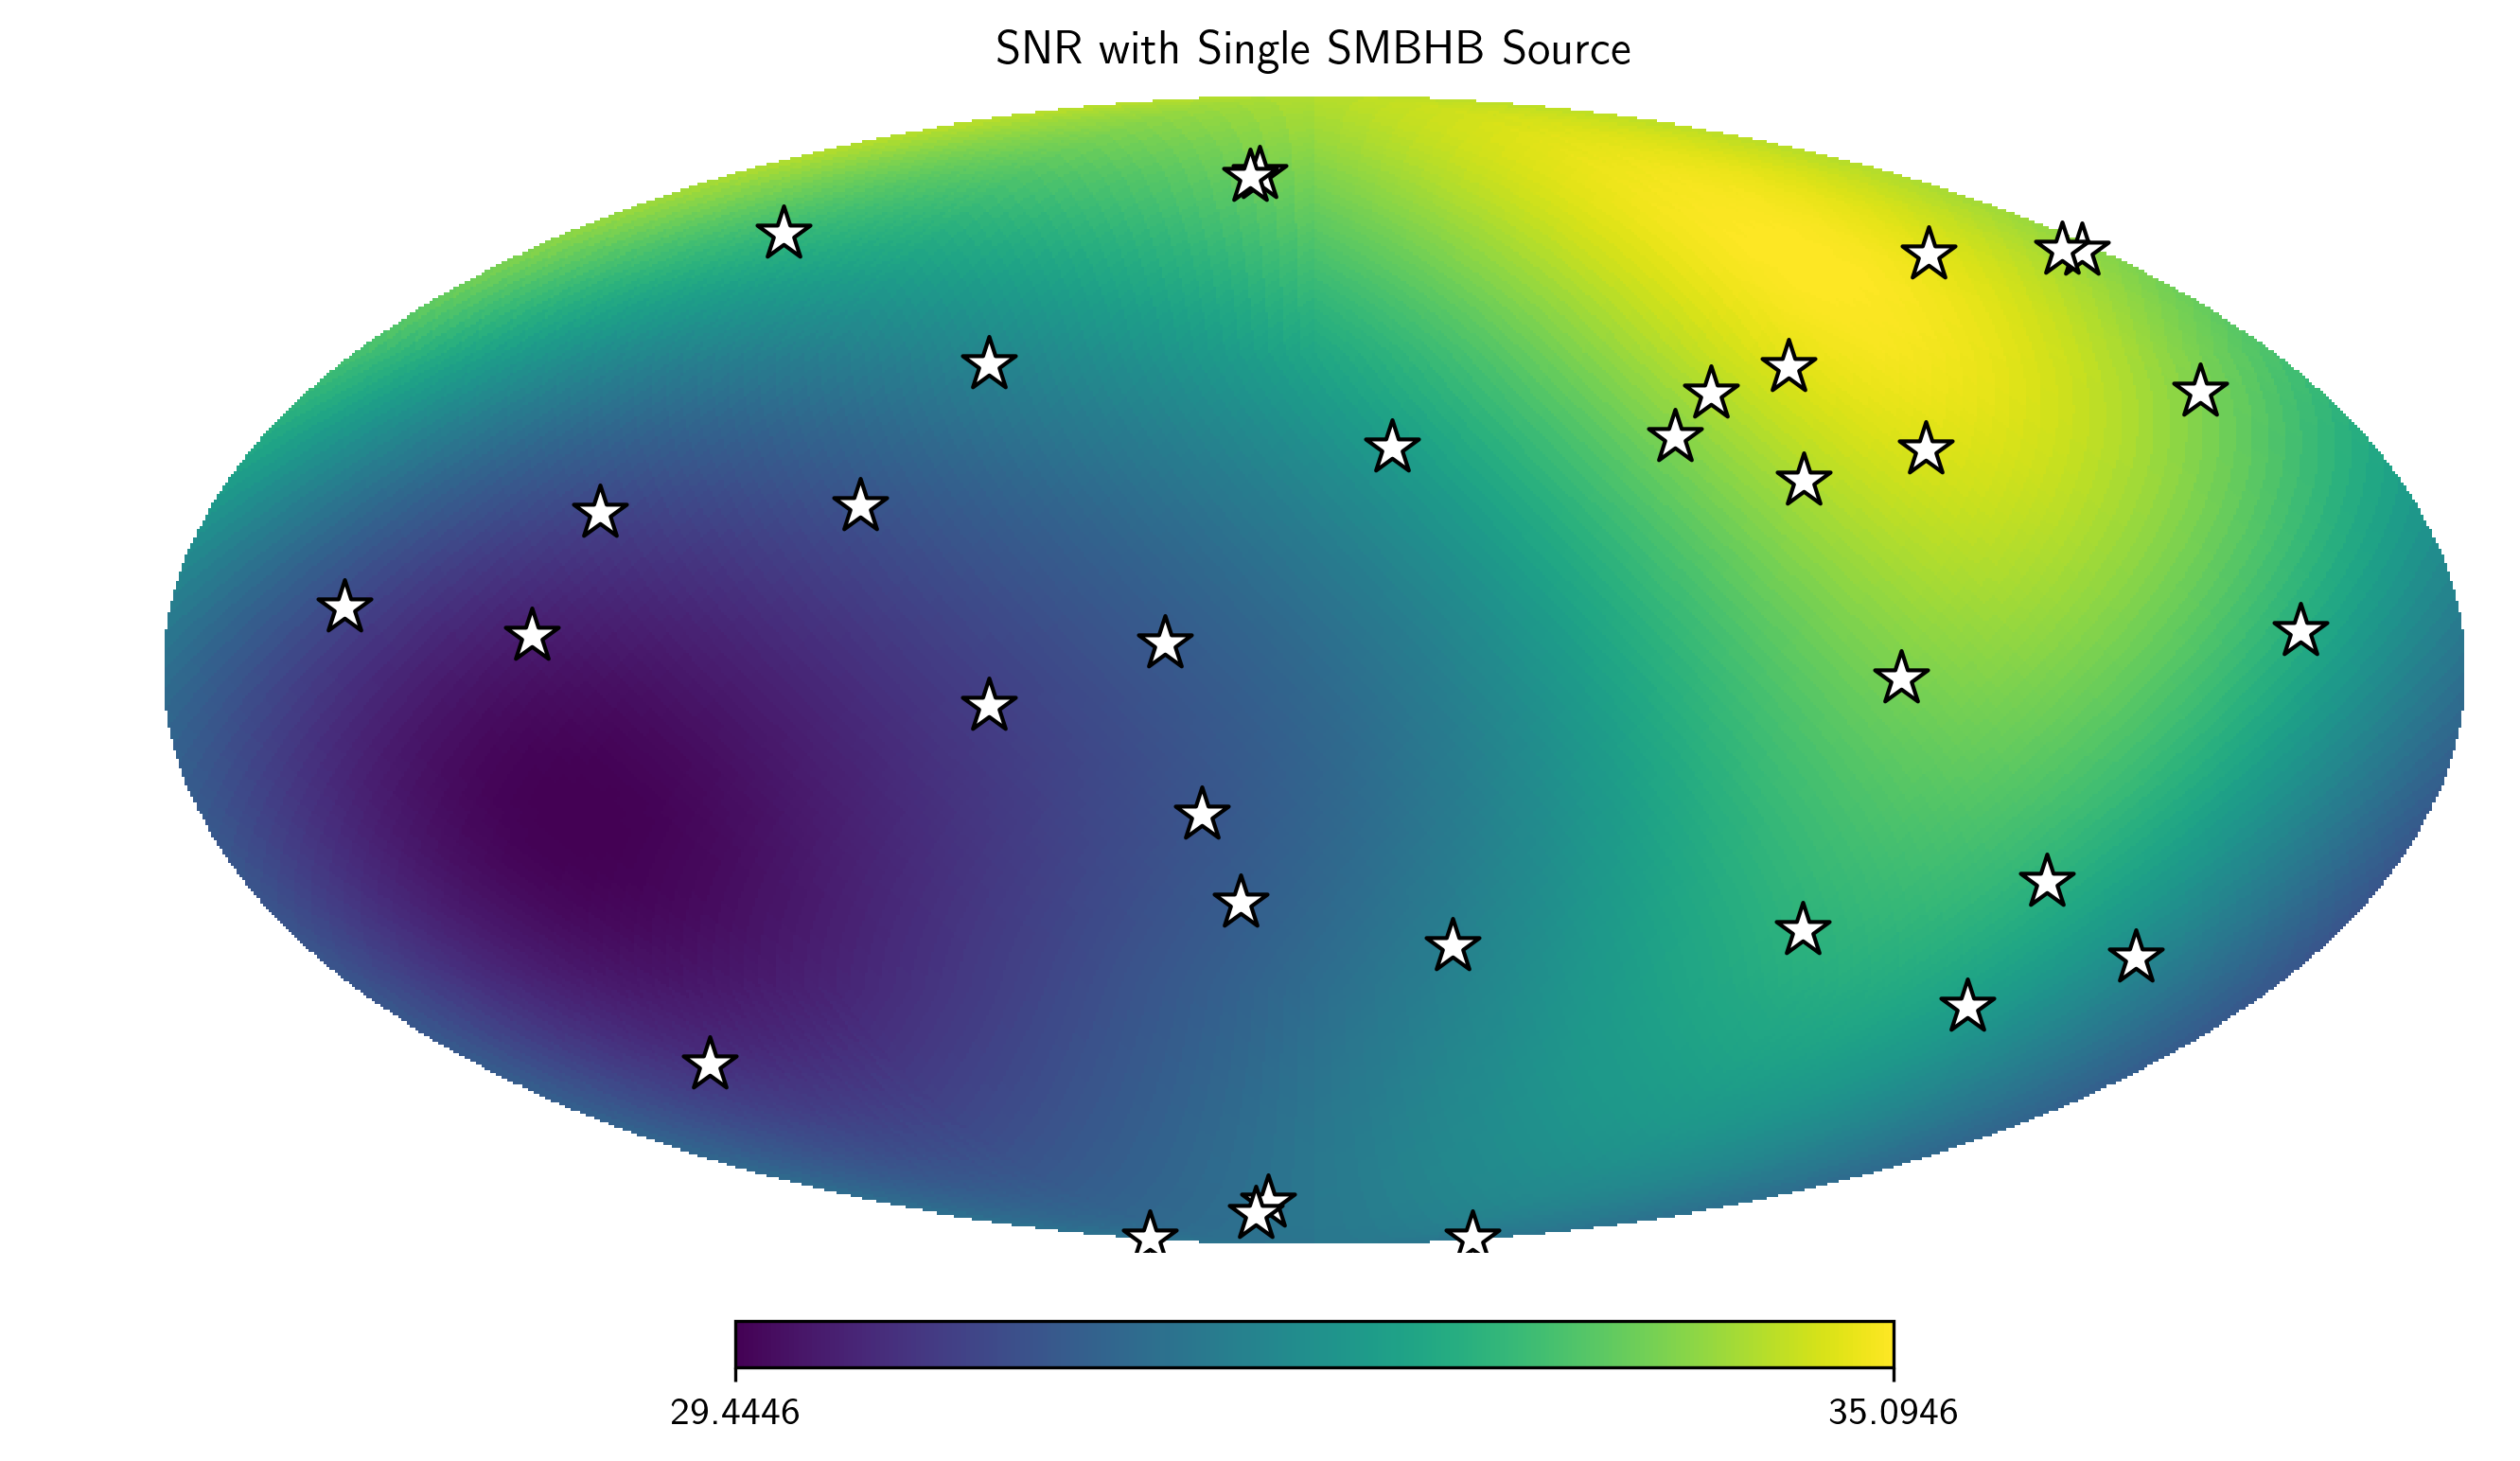

In [17]:
idx = 167
hp.mollview(SNR,
            title="SNR with Single SMBHB Source",
            cmap='viridis')
hp.visufunc.projscatter(SM.thetas,SM.phis,marker='*',
                        color='white',edgecolors='k',s=200)
plt.show()

In [18]:
h_divA = (hsky.h_circ(1e9,200,5e-9,Tspan,SM.freqs)
          /hsky.h0_circ(1e9,200,5e-9)).value

In [ ]:
Amp = SM.A_gwb(h_divA)

In [ ]:
hp.mollview(Amp,
            title="Amplitude Needed for an SNR=1 detection.",
            cmap='viridis')
hp.visufunc.projscatter(SM.thetas,SM.phis,marker='*',
                        color='white',edgecolors='k',s=200)
plt.show()